In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

def Gauss(x, u, s):
    d = x.shape[0]

    a = np.exp(-0.5*(x-u) @ np.linalg.inv(s) @ (x-u).T)
    S = np.abs(np.linalg.det(s))**(-0.5)

    return ((2*math.pi)**(-d/2))*S*a

def GMM(X, K):
    #Gaussian mixture model
    #X:data, K:number of components

    
    D = X.shape[1] #dimenionality of the data
    N = X.shape[0] #no of samples
    U = X[np.random.choice(N, K)] #initializing means as some K points in the data
    
    cov = np.cov(X, rowvar=False)
    
    #S = np.random.rand(K, D, D)*50 #variances
    S = np.stack([cov for k in range(K)], axis=0) #setting cov matrix of the data as guess for S
    
    #P = np.random.rand(K); P = np.exp(P); P = P/sum(P); #pi's, the contribution of each component
    P = np.ones(K)/K
    G = np.zeros((N,K))

    def gamma(n, k):
        sum = 0;
        for j in range(K):
            sum += P[j]*Gauss(X[n], U[j, :], S[j, :, :]);
            #print('sum = ', sum);
        return P[k]*Gauss(X[n], U[k, :], S[k, :, :])/sum;

    l_old = -1
    thresh = 1e-3
    iterations = 0
    loss_hist = []

    while(True):
        #E_step
        #print('iter = {}, l = {}'.format(iterations, l_old))
        for i in range(N):
            for j in range(K):
                G[i, j] = gamma(i, j)

        #M step
        N_k = np.sum(G, axis = 0)
        #print('G.T:{}, X:{}, N_k:{}'.format(G.T.shape, X_train.shape, N_k.shape))
        U = (G.T @ X)/(N_k[:, np.newaxis])
        for k in range(K): #improve by using broadcasting!
            #print((X_train - U[k,:]).shape)
            #print(G[:, k].shape)
            S[k, :] = ((X - U[k, :]).T @ (G[:,k][:,np.newaxis]*(X - U[k, :])))/N_k[k]
        P = N_k/N

        #computing likelihood
        l = 0
        for i in range(N):
            s = 0
            for j in range(K):
                s += P[j]*Gauss(X[i], U[j, :], S[j, :, :])
                #print(s)
            l += np.log(s)
        #input()
        loss_hist.append(l)
        if np.abs(l - l_old) < thresh and iterations != 0:
            break;
        iterations += 1
        l_old = l
    print('Done.')
    return P, U, S, loss_hist

#function to evaluate p(x) given parameters of GMM
def calc_p_gmm(x, a):
    #x: input point, a:parameters, returned from function GMM
    P = a[0]
    U = a[1]
    S = a[2]
    K = P.shape[0]
    sum = 0
    for k in range(K):
        sum += P[k]*Gauss(x, U[k, :], S[k, :, :])
    return sum

In [2]:
#Does my gmm even work? Lets find out!
#lets do it in 2-d, so that way it will be visible.
u0 = np.array([3.12, 4.21]);
s0 = np.array([[2.3, 0.1],[0.1, 5.1]])
p0 = 0.3

u1 = np.array([10.2, 12.1])
s1 = np.array([[5.1, 2.3], [2.3, 7.7]]);
p1 = 1 - p0

X_ = []
N_samples = 1000
for i in range(N_samples):
    a = np.random.choice(2, p=[p0, p1])
    if(a == 0):
        X_.append(np.random.multivariate_normal(mean = u0, cov = s0))
    elif(a==1):
        X_.append(np.random.multivariate_normal(mean=u1, cov=s1))
X_ = np.array(X_)

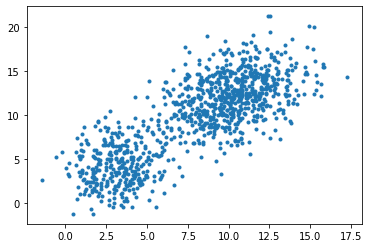

In [3]:
plt.plot(X_[:,0], X_[:,1], '.')

Done.


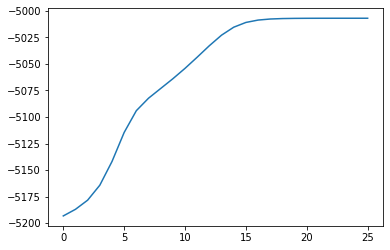

In [4]:
a_ = GMM(X_, 2);
plt.plot(a_[3])

[]

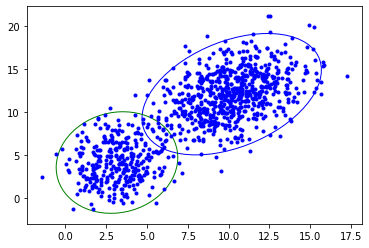

In [6]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

U = a_[1]
P = a_[0]
S = a_[2]
def confidence_ellipse(cov, u, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    



    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = u[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = u[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
fig, ax = plt.subplots()
ax.plot(X_[:,0], X_[:, 1], 'b.')
confidence_ellipse(S[0], U[0], ax, n_std=2.5, edgecolor='blue')
confidence_ellipse(S[1], U[1], ax, n_std =2.5, edgecolor='green')
plt.plot()

# The GMM Code works!!